In [ ]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import loadtxt, zeros, ones, array, linspace, logspace

# L1 - Градиентый спуск и линейные модели

### 1. Линейные модели

Пусть есть обучающая выборка $\{x_i\}_{i=1}^{\mathcal{l}} \subset \mathbb{R}^{n}$, при этом каждому объекту в соответсвие поставлена метка класса $y_{i} \in \{-1, +1\}$. Мы предполагаем, что в пространтсве $\mathbb{R}^{n}$ существует гиперплоскость, которая относительно некоторой метрики "хорошо" разделяет объекты на два класса. При этом гиперплоскость задается параметрически:

<center>
$wx + b = 0$
</center>

Объект $x$ имеет метку $y = +1$, если $wx + b \geq 0$ и $y = -1$ в ином случае. Вектор $w$ является нормалью к гиперплоскости, указывающий с какой стороны находятся объекты класса $y = +1$.

### 2. Обучение

Поиск модели ограничен до одного семейства, заданного параметрически. Обучение в таком случае сводится к задаче оптимизации эмпирического риска

<center>
$\arg \min_{\theta} Q(\theta) = \arg \min_{\theta} \frac{1}{l}\sum_{i=1}^{\mathcal{l}} \mathcal{L}(a(x_i|\theta), y_i)$, где
</center>

* $a(x|\theta)$ - алгоритм из некотрого семейства, заданный параметром $\theta$
* $\theta$ - вектор пространства параметров
* $\mathcal{L}$ - функция потерь, которая показывает на сколько точно предсказание

Очевидно, что качество предсказания зависит от выбранной модели. Но также оно зависит и от выбора функции потерь $\mathcal{L}$, которая существенно влияет на процесс обучения.

### 3. Функция потерь

В литературе можно встретить такое понятие, как отступ
<center>$ M(x, y) = y\cdot(wx + b)$,</center>
его можно трактовать, как уровень удаление от гиперплоскости в сторону своего класса. Это позволит нам кратко записывать функции потерь.

Наиболее естественной функцией потерь для задачи классификации является относительное количество неправильных классификаций, то есть
<center>$ \mathcal{L}(y_{pred}, y_{true}) = [y_{pred} \neq y_{true}] = [M(x, y_{true}) < 0]$</center>

Решение такой задачи является очень трудоемким, поэтому на практике производят оптимизацию реклаксированной ошибки.

К примеру **квадратичная ошибка**

<center>$ Q(w) = \frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}}((wx_i+b) - y_i)^{2}$</center>

Она многим хороша, к примеру, в задачи оптимизации все сводится к выпуклому функционалу с локальным минимумом. Если представить, что признаки объекта $x_i$ записаны в матрицу $X$ построчно, а все метки записаны в вектор-столбец $Y$, то задача выглядит

<center>
$\arg\min_{w}||Xw - Y ||_{2}$,
</center>

и имеет аналитическое решение

<center>
$w = (X^TX)^{-1}X^TY$.
</center>

**Задание**

1. Сгенерируйте на плоскости 2 облака точек. Они должны слегка пересекаться, а точки внутри распределены нормально.
2. Обучите линейную модель, разделяющую два облака точек, использую формулу выше.
3. Изобразите облака с помощью библиотеки matplotlib, воспользуйтесь функцией scatter, для удобства точки можно сделать прозрачными.
4. Постройте полученнную разделяющую прямую.
5. Оцените сложность алгоритма обучения.

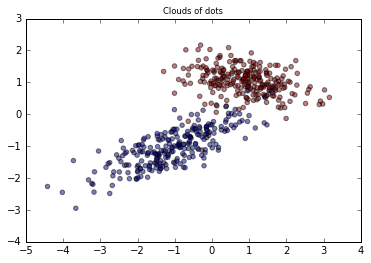

In [660]:
from sklearn.datasets import make_classification

plt.title("Clouds of dots", fontsize='small')
X1, Y1 = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, alpha=0.5)


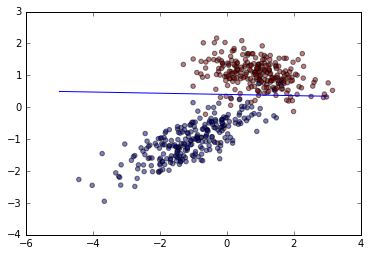

In [661]:
X1 = np.array(X1)
Y1 = np.array(Y1)

def min_square(X, Y):
    return np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y.T)

plt.figure()
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, alpha=0.5)
line = min_square(X1,Y1)
plt.plot([i for i in range(-5,4)], [line[0] * x + line[1] for x in range(-5,4)])

Сложность алгоритма состоит из 2 элементов, перемножения матриц, и их обращения, т.к каждый из них выполняется за время $ O(n ^{3}) $, итоговая сложность алгоритма будет составлять $ O(n ^{3}) $.

Еще популярна следующая релаксация
<center>$Q(w) = \frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} max(0, 1 - y_i\cdot(wx_i + b))$,</center>
если хотите узнать об этом более подробно, то вам стоит почитать про svm (support vector machine).

Логистическая функция же обладает вероятностным смыслом

<center>$ Q(w) = \frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} \ln(1 + \exp(-y_i\cdot(wx_i + b)))$</center>
В частности данный функционал приводит нас к оптимальному байесовскому классификатору при некоторых допущениях о распределении признаков. Но это совершенно отдельная история.

### 4. Градиентный спуск

Для задачи оптимизации не всегда существует аналитическое решение, либо оно может быть очень сложным. В таком случае используют численные методы. Да, речь идет именно о градиентном спуске. Это итеративный алгоритм, который устроен следующим образом. Пусть есть $Q(x)$, которую необходимо оптимизировать и она дифференцируема. Тогда задачу

<center>$ \arg\min_{x} Q(x)$</center>

можно решить следующим образом

<center>$ x^{k+1} = x^{k} - \lambda \cdot \triangledown Q(x)$,</center>

где $\lambda$ - некоторый шаг градиентного спуска, а $k$ - номер этого шага.

От выбора правильного $\lambda$ сильно зависит процесс обучения. Если взять слишком большое значение, то алгоритм может не сойтись. Если слишком малое, то обучение будет длиться долго. Также существует распространенный прием, применяемый часто при обучении нейросетей, уменьшать значение $\lambda$ в соответствии с некоторым расписанием.

**Задание**
1. Предложите какую-нибудь квадратичную функцию с глобальным минимумом.
2. Найдите минимум методом градиентного спуска.
3. Отобразите на плоскости линии уровней функции, которую вы оптимизируете.
4. Покажите, какую траекторию проходит алгоритм градиентного спуска.
5. Как вы выбрали значение $\lambda$?

### Пусть наша функция будет: $ Q(x,y) = x^2 + xy + y^2 - 2x + y $

In [665]:
import numpy as np

def compute_grad(x):
    return np.array([2*x[0] + x[1] - 2, x[0] + 2*x[1] + 1])
    
def function_val(x):
    return x[0] ** 2 + x[1]*x[0] + x[1] ** 2 - 2*x[0] + x[1]


optim_alpha_iters = []
alpha = 0.01
grad_val_x = []
grad_val_y = []
for i in range(1,100):
    x = np.array([-3,-4])
    n_iter = 0
    while (abs(x[0] - 5/3) > 0.01 and abs(x[1] + 4/3) > 0.01):
        x_new = x - i * alpha * compute_grad(x)
        x = x_new
        n_iter += 1
        grad_val_x.append(x[0])
        grad_val_y.append(x[1])
        if (n_iter > 2000):
            break
    optim_alpha_iters.append(n_iter)
    


In [666]:
best_alpha = 9999
best_num = 9999

for i in range(len(optim_alpha_iters)):
    if (optim_alpha_iters[i] < best_num):
        best_num = optim_alpha_iters[i]
        best_alpha = i

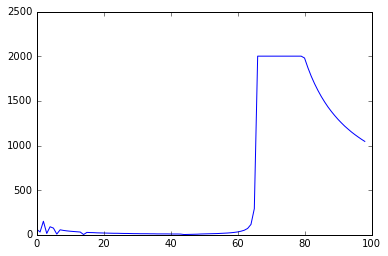

In [667]:
plt.plot(optim_alpha_iters)

In [668]:
x = np.array([-3,-4])
n_iter = 0
alpha = 0.01 * best_alpha
tol = 10 ** (-9)

grad_val_x = []
grad_val_y = []

while (abs(x[0] - 5/3) > tol and abs(x[1] + 4/3) > tol):
    x_new = x - alpha * compute_grad(x)
    x = x_new
    n_iter += 1
    grad_val_x.append(x[0])
    grad_val_y.append(x[1])

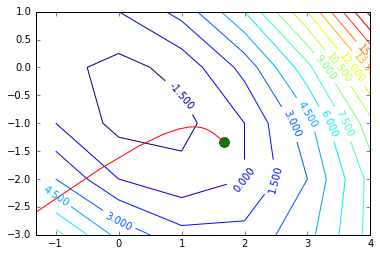

In [669]:
import numpy, pylab
import matplotlib.pyplot as plt
%matplotlib inline

def makeData():
    x = [i for i in range(-1,5)]
    y = [i for i in range(-3,2)]
    xgrid, ygrid = numpy.meshgrid(x, y)

    zgrid = ygrid ** 2 + xgrid ** 2 + xgrid * ygrid + ygrid - 2
    return xgrid, ygrid, zgrid

x, y, z = makeData()
cs = pylab.contour(x, y, z, 20)
pylab.clabel(cs)
plt.plot([5/3],[-4/3],marker="o", markersize=10, color="green")
plt.plot(grad_val_x, grad_val_y, color = 'red')

Существуют функции, которые плохо даются градиентному спуску. К примеру, функция Розенброка

<center>$f(x, y) = (1-x)^2 + 100(y-x^2)^2$.</center>

**Задание**
1. Проделайте все то же самое для функции Розенброка.
2. Какую проблему вы наблюдаете?
3. Как ее можно решить?

In [670]:
import numpy as np

def compute_grad_resonebrock(x):
    return np.array(2*(200 * x[0]**3 - 200 * x[0] * x[1] + x[0] - 1), 200*(x[1] - x[0] ** 2))
    
def rosenbrock_function_val(x):
    return (1-x[0]) ** 2 + 100 *(x[1] - x[1] ** 2)**2


optim_alpha_iters = []

tol = 0.00001

alpha = 0.0001

for i in range(1, 200):
    x = np.array([-3, 4])
    n_iter = 0
    while (abs(x[0] - 1) > tol and abs(x[1] - 1) > tol):
        x_new = x - i * alpha * compute_grad_resonebrock(x)
        x = x_new
        n_iter += 1
        grad_val_x.append(x[0])
        grad_val_y.append(x[1])
        if (n_iter > 10000):
            break
    optim_alpha_iters.append(n_iter)

best_alpha = 9999
best_num = 9999

for i in range(len(optim_alpha_iters)):
    if (optim_alpha_iters[i] < best_num):
        best_num = optim_alpha_iters[i]
        best_alpha = i

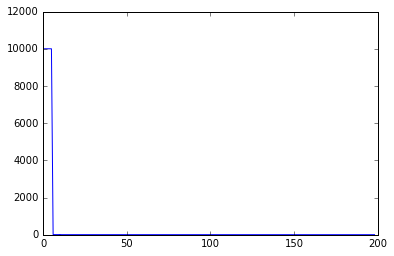

In [671]:
plt.plot(optim_alpha_iters)

In [672]:
x = np.array([-3,-4])
n_iter = 0
alpha = 0.0001 * best_alpha
tol = 10 ** (-9)

grad_val_x = []
grad_val_y = []

while (abs(x[0] - 5/3) > tol and abs(x[1] + 4/3) > tol):
    x_new = x - alpha * compute_grad(x)
    x = x_new
    n_iter += 1
    grad_val_x.append(x[0])
    grad_val_y.append(x[1])

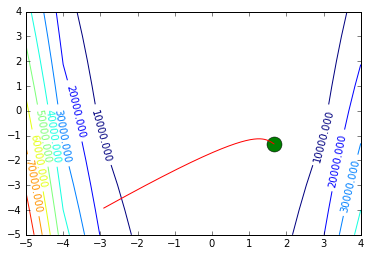

In [673]:
import numpy, pylab
import matplotlib.pyplot as plt
%matplotlib inline

def makeData():
    x = [i for i in range(-5,5)]
    y = [i for i in range(-5,5)]
    xgrid, ygrid = numpy.meshgrid(x, y)

    zgrid = (1 - xgrid) ** 2 + 100*(ygrid - xgrid ** 2)** 2
    return xgrid, ygrid, zgrid

x, y, z = makeData()
cs = pylab.contour(x, y, z, 10)
pylab.clabel(cs)
plt.plot([5/3],[-4/3],marker="o", markersize=15, color="green")
plt.plot(grad_val_x, grad_val_y, color = 'red')

Возникла проблема с расходимостью метода, при ограничении до 100 000 итераций, градиентный спуск все равно не сходился. Решилось с помощью понижения альфа в 100 раз

Существуют различные модификации алгоритма градиентного спуска. К примеру, метод наискорейшего спуска, где значение $\lambda$ зависит от шага

<center>$\lambda^{k} = \arg\min_{\lambda}Q(x_k - \lambda\triangledown Q(x_k))$.</center>

**Задание**
1. Снова разделите облака точек, только теперь оптимизируйте квадратичную ошибку метода градиентного спуска.
2. Отобразите полученную прямую и облака точек.
3. Сравните ответ с точным решением.
4. Попробуйте метод наискорейшего спуска.
5. Постройте график в осях (номер шага и значение $Q$).
6. Сравните скорость сходимости обычного и наискорейшего спуска.

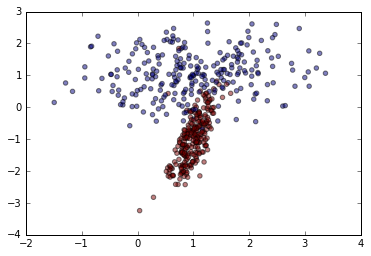

In [688]:
from sklearn.datasets import make_classification

X1, Y1 = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, alpha=0.5)

Разница точного метода и град.спуска [-0.03887112  0.06595762]
Разница точного метода и наискорейшего спуска [  1.05471187e-15  -1.66533454e-15]


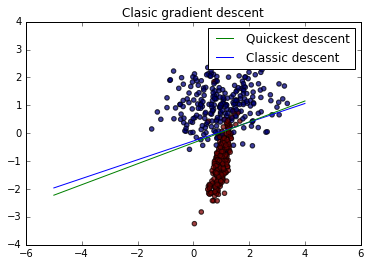

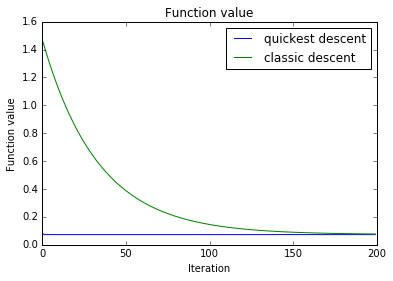

In [710]:
def min_sqr_func(X, y, theta):
    
    m = y.size

    predictions = X.dot(theta).flatten()

    sqErrors = (predictions - y) ** 2

    J = (1.0 / (2 * m)) * sqErrors.sum()

    return J


def gradient_descent(X, y, theta, alpha, num_iters):
    m = y.size
    history = []
    
    for i in range(num_iters):
        predictions = X.dot(theta).flatten()

        errors_x1 = (predictions - y) * X[:, 0]
        errors_x2 = (predictions - y) * X[:, 1]
        
        theta[0][0] = theta[0][0] - alpha * (1.0 / m) * errors_x1.sum()
        theta[1][0] = theta[1][0] - alpha * (1.0 / m) * errors_x2.sum()
        history.append(min_sqr_func(X,y,theta))

    return theta, history

def quickest_descent(X, y, theta, alpha, num_iters):
    m = y.size
    history = []
    
    for i in range(num_iters):
        predictions = X.dot(theta).flatten()

        errors_x1 = (predictions - y) * X[:, 0]
        errors_x2 = (predictions - y) * X[:, 1]
        
        cur_errors = np.array([[(1.0 / m) * errors_x1.sum()], [(1.0 / m) * errors_x2.sum()]])
        
        temp_max = 10 ** 10
        
        for i in range(1,100):
            if (temp_max > min_sqr_func(X,y, theta - 0.01 * i * cur_errors)):
                temp_max = min_sqr_func(X,y, theta - 0.01 * i * cur_errors)
                alpha = i * 0.01
    

        theta[0][0] = theta[0][0] - alpha * (1.0 / m) * errors_x1.sum()
        theta[1][0] = theta[1][0] - alpha * (1.0 / m) * errors_x2.sum()
        
        history.append(min_sqr_func(X,y, theta))

    return theta, history


theta, hist_grad = gradient_descent(X1, Y1, [[0],[1]], 0.01, 200)

k = theta[0][0]
b = theta[1][0]

plt.title("Clasic gradient descent")
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, alpha=0.5)
classic, = plt.plot([i for i in range(-5,5)], [k*i + b for i in range(-5,5)],label= "Classic descent")

print("Разница точного метода и град.спуска", [k,b]- min_square(X1,Y1))

theta, hist_quick = quickest_descent(X1, Y1, [[0],[1]], 0.01, 200)

k = theta[0][0]
b = theta[1][0]

plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1, alpha=0.5)
quick, = plt.plot([i for i in range(-5,5)], [k*i + b for i in range(-5,5)], label="Quickest descent")
                  
pylab.legend(handles=[quick, classic])                  


print("Разница точного метода и наискорейшего спуска", [k,b]- min_square(X1,Y1))

plt.figure()

plt.title("Function value")
quick, = plt.plot([i for i in range(200)], hist_quick, label='quickest descent')


#plt.title("Function value for iteration")
classic, = plt.plot([i for i in range(200)], hist_grad, label='classic descent')
plt.xlabel("Iteration")
plt.ylabel("Function value")
pylab.legend()

Как видно из 2 графика метод наискорейшего спуска работает значительно быстрее

И еще немного о проблемах градиентного спуска. Если у нас есть какие-то признаки, которые встречаются достаточно редко, то соответствующий столбец будет разряженным.

**Задание**
В чем заключается проблема?

Проблема заключается в том, что данные признаки будут слабо влиять на градиент и может потребоваться очень много данных, чтобы такой градиент сошелся до необходимого оптимума.

Также нужно понимать, что градиентный спуск может попасть в "ловушку" локального минимума. Обычно это актуально для нейросетей. Самый простой способо решить эту проблема - сдедать несколько запусков алгоритма или иметь какой-то инсайд, из какой точки стоит начинать.

### 5. Стохастический градиентный спуск

Иногда количество данных может быть так велико, что даже градиентный спуск начинает работать медленно. Или же данные просто поступают к нам большим потоком, а параметры модели постепенно меняются. Тогда на сцену выходит метод стохастического градиента.

Идея пределельно проста. Можно делать шаг спуска, вычисляя ошибку и градиент не для всех элементов выборки, а для какого-то небольшого количества или даже для одного объекта.

**Задание**

1. Скачайте данные mnist c [Kaggle](https://www.kaggle.com/c/digit-recognizer).
2. Обучите линейный классификатор 0 и 1, используйте логистическую функцию потерь.
3. Проверьте качество классификации на отложенной выборке.
<center>$ \mathcal{L}(y_{pred}, y_{true}) = [y_{pred} \neq y_{true}]$ </center>
4. Как влияет размер батча на скорость и качество обучения?
5. Отобразите графики, которые доказывает ваши слова (оси придумайте сами).
6. Сколько проходов по данным вы делаете? Почему?


In [690]:
import pandas as pd


from sklearn.model_selection import train_test_split

data = pd.read_csv("train.csv")

data_0 = data[data.label == 0]
data_1 = data[data.label == 1]

In [691]:
data = pd.concat([data_0, data_1])

In [692]:
data_y = data['label']
del data['label']

In [693]:
data = data.as_matrix()
data_y = data_y.tolist()

In [694]:
X_train, X_test, Y_train, Y_test = train_test_split(data, data_y, test_size=0.2, random_state=128)

In [695]:
import time
def batch_gen(X, y, n):
    for i in range(0, len(X), n):
        yield X[i:i+n], y[i:i+n]

        
def stohastic_logistic_gradient_descent(X, y, theta, alpha, num_iters, batch_size):
    m = len(y)
    history = []
    shuffledRange = list(range(len(X)))
    
    for i in range(num_iters):
        
        random.shuffle(shuffledRange)
        shuffledX = [X_train[i] for i in shuffledRange]
        shuffledY = [Y_train[i] for i in shuffledRange]
        for batch_x, batch_y in batch_gen(X,y, batch_size):
            theta = theta - (alpha/m) * batch_x.T.dot( (1./(1+np.exp(-batch_x.dot(theta))) - batch_y));
    return theta

def predict_stohastic_descent(theta, X_test):
    ans = []
    for elem in theta.dot(X_test.T):
        if (elem >= 0):
            ans.append(0)
        else:
            ans.append(1)
    return ans

def accuracy(X_pred, Y_test):
    err = 0
    ok = 0
    for i in range(len(X_pred)):
        if X_pred[i] == Y_test[i]:
            ok += 1
        else:
            err += 1
    return err/len(X_pred)

ans = stohastic_logistic_gradient_descent(X_train, Y_train,
                                          np.array([0 for i in range(len(X_train[0]))]), 0.01, 1, 1000)
print("Accuracy for stohastic gradient is", accuracy(predict_stohastic_descent(ans, X_test), Y_test))


acc = []
time_score = []
batches = [1,2,5,10,15,30,50,100,300,500,1000,2000,5000]

for batch_size in batches:
    begin = time.time()
    ans = stohastic_logistic_gradient_descent(X_train, Y_train,
                                          np.array([0 for i in range(len(X_train[0]))]), 0.001, 1, batch_size)
    time_score.append(time.time() - begin)
    acc.append(accuracy(predict_stohastic_descent(ans, X_test), Y_test))

Accuracy for stohastic gradient is 0.9965986394557823


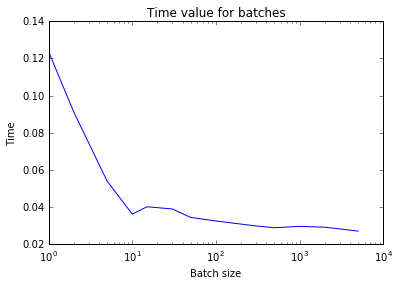

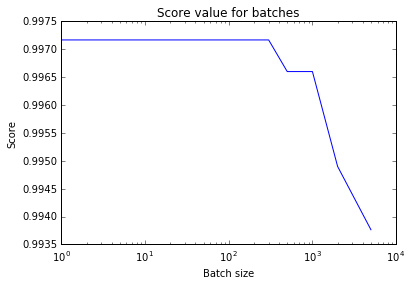

In [696]:
plt.title("Time value for batches")
plt.xlabel("Batch size")
plt.ylabel("Time")
plt.semilogx(batches,time_score)

plt.figure()

plt.title("Score value for batches")
plt.xlabel("Batch size")
plt.ylabel("Score")
plt.semilogx(batches,acc)

По данным делается 1 проход для более честного сравнения с классической реализацией

У стохастического градиентного спуска также есть много всяких усовершествований, которые часто используются в реальной практике при обучении нейросетей.

**Сохранение импульса**

Сохранения импульса позволяет избежать нам осциляции вдоль оси, по которой функция изменяется сильнее. Он заключается в том, что текущий градиентный шаг вычисляется на основе учета предыдущих шагов
<center> $x^{k+1} = x^{k} - s^{k}$,</center> где $s^k = \gamma s^{k-1} + \lambda\triangledown Q(x^k)$, при этом
 * $0 <\gamma < 1$ - коэффициент учета предыдущего импульса
 * $s^{-1} = 0$

**Задание**

1. Найдите минимум $Q(x, y) = 10x^2 + y^2$ c помощью обычного метода.
2. Воспользуйтесь методом сохранения импульса
3. Отобразите и сравните треки.
4. На основе чего вы выбрали $\gamma$?

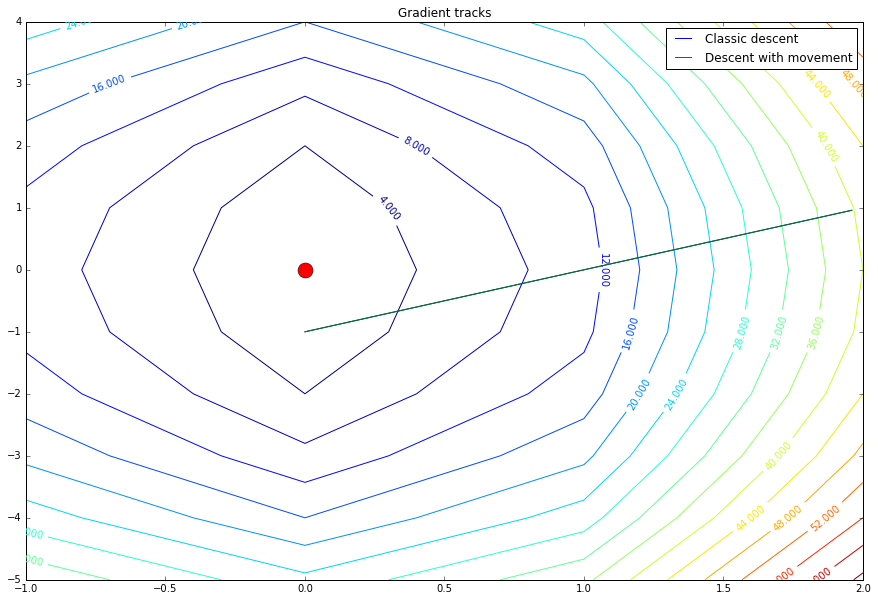

In [697]:
import matplotlib.pylab as pylab
def func(theta):
    return 10*theta[0]**2 + theta[1] **2

def grad_func_standart(theta):
    return np.array(20*theta[0], 2*theta[1])

def grad_descent(n_iter,alpha, theta):
    history = [[],[]]
    
    for i in range(n_iter):
        theta = theta - alpha * grad_func_standart(theta)
        history[0].append(theta[0])
        history[1].append(theta[1])
    return theta, history

clas_theta, hist_clas = grad_descent(1000, 0.001, np.array([2,1]))

def grad_des_movement(n_iter, alpha, theta, y):
    history = [[],[]]
    s = 0
    
    for i in range(n_iter):
        s =  -y*s - alpha * grad_func_standart(theta)
        theta = theta + s
        history[0].append(theta[0])
        history[1].append(theta[1])
    return theta, history


max_dist = 9999
best_y = 2
for i in range(1000):
    mov_theta, mov_history = grad_des_movement(1000, 0.01, np.array([2,1]), 0.001 * i)
    delta = (mov_theta[0] ** 2 + mov_theta[1] ** 2) **1/2
    if (max_dist > delta):
        best_y = i
        max_dist = delta

mov_theta, mov_history = grad_des_movement(1000, 0.001, np.array([2,1]), 0.001 *best_y)        


def makeData():
    x = [i for i in range(-1,3)]
    y = [i for i in range(-5,5)]
    xgrid, ygrid = np.meshgrid(x, y)

    zgrid = 10 * xgrid **2 + ygrid **2
    return xgrid, ygrid, zgrid
plt.figure(figsize=(15,10))
plt.title("Gradient tracks")
x, y, z = makeData()
cs = pylab.contour(x, y, z, 20)
pylab.clabel(cs)

plt.plot([0],[0], marker="o", markersize=15, color="red")

first, = plt.plot(hist_clas[0],hist_clas[1], label="Classic descent")
sec, = plt.plot(mov_history[0],mov_history[1], label="Descent with movement")
pylab.legend()

Как видно из кода, $\gamma$ был выбран путем перебора возможных значений и остановке на оптимуме

**Ускоренный градиент Нестерова**

И логическое развитие этого подхода приводит к методу ускоренного градиента Нестерова. Шаг спуска вычисляется немного иначе
<center>$s^k = \gamma s^{k-1} + \lambda\triangledown Q(x^k - s^{k-1})$,</center>
то есть мы вычисляем градиент фукнции примерно в той точке, куда "занесет" нас накопленный импульс.

**Задание**

1. Сравните этот метод и предыдущий на функции Розенброка.
2. Отобразите и сравните треки.

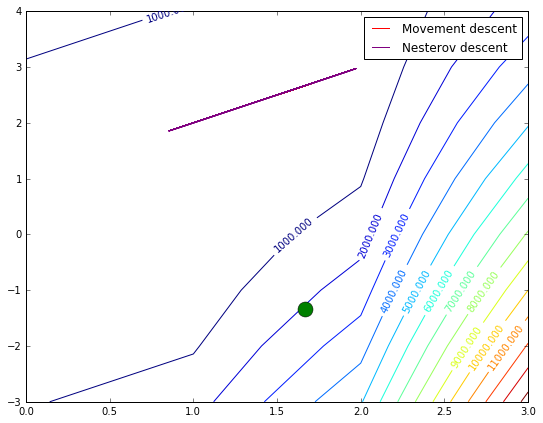

In [698]:
def makeData():
    x = [i for i in range(0,4)]
    y = [i for i in range(-3,5)]
    xgrid, ygrid = np.meshgrid(x, y)

    zgrid = (1 - xgrid) ** 2 + 100*(ygrid - xgrid ** 2)** 2
    return xgrid, ygrid, zgrid

def compute_grad_resonebrock(x):
    return np.array(2*(200 * x[0]**3 - 200 * x[0] * x[1] + x[0] - 1), 200*(x[1] - x[0] ** 2))


def grad_des_movement(n_iter, alpha, theta, y):
    history = [[],[]]
    s = 0
    
    for i in range(n_iter):
        s =  -y*s - alpha * compute_grad_resonebrock(theta)
        theta = theta + s
        history[0].append(theta[0])
        history[1].append(theta[1])
    return theta, history

def grad_des_nesterov(n_iter, alpha, theta, y):
    history = [[],[]]
    s = 0
    
    for i in range(n_iter):
        s =  -y*s - alpha * compute_grad_resonebrock(theta - s)
        theta = theta + s
        history[0].append(theta[0])
        history[1].append(theta[1])
    return theta, history

theta_mov, hist_ros_mov = grad_des_movement(100, 0.001, np.array([1,2]), 0.3)
theta_nest, hist_ros_nest = grad_des_nesterov(100, 0.001, np.array([1,2]), 0.1)

plt.figure(figsize=(9,7))
x, y, z = makeData()
cs = pylab.contour(x, y, z, 15)
pylab.clabel(cs)
plt.plot([5/3],[-4/3],marker="o", markersize=15, color="green")
plt.plot(hist_ros_mov[0], hist_ros_mov[1], label='Movement descent', color='red')
plt.plot(hist_ros_nest[0], hist_ros_nest[1], label='Nesterov descent', color='purple')
pylab.legend()

**Adagrad (2011)**

Адаптивный градиент подразумевает вычисление $\lambda$ для каждой размерности входного вектора $x$. Неформально говоря, для разряженных признаков он делает больший шаг, а для обычных шаг поменьше.
<center> $x_{i}^{k + 1} = x_{i}^{k} - \frac{\lambda}{\sqrt{G_{i, i}^k } + \varepsilon} \cdot \frac{\partial Q}{\partial x_i}(x^k)$, где 
</center>


* $G^{k} = \sum_{t=1}^{k}g_t g_t^{T}$, где $g_t = \triangledown Q(x^t)$.
* $\varepsilon$ - небольшая добавка, чтобы избежать деление на ноль.

Как ни странно это улучшает сходимость процесса обучение, к примеру, при работе нейросетей с текстами.

**Задание**

1. Обучите модель этим способом для mnist.
2. Сравните сходимость с обычным стохастическим градиентным спуском (графики).

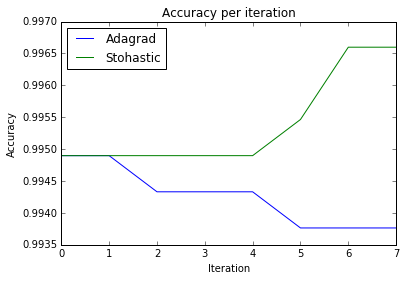

In [709]:
import time
def batch_gen(X, y, n):
    for i in range(0, len(X), n):
        yield X[i:i+n], y[i:i+n]

        
def stohastic_logistic_gradient_descent(X, y, theta, alpha, num_iters, batch_size):
    m = len(y)
    history = []
    shuffledRange = list(range(len(X)))
    
    for i in range(num_iters):
        
        random.shuffle(shuffledRange)
        shuffledX = [X_train[i] for i in shuffledRange]
        shuffledY = [Y_train[i] for i in shuffledRange]
        for batch_x, batch_y in batch_gen(X,y, batch_size):
            theta = theta - (alpha/m) * batch_x.T.dot( (1./(1+np.exp(-batch_x.dot(theta))) - batch_y));
            history.append(accuracy(predict_stohastic_descent(theta, X_test), Y_test))
    return theta, history

def adagrad(X, y, theta, alpha, num_iters, batch_size):
    m = len(y)
    history = []
    shuffledRange = list(range(len(X)))
    
    #temp_x = []
    g = 0
    
    for i in range(num_iters):
        
        random.shuffle(shuffledRange)
        shuffledX = [X_train[i] for i in shuffledRange]
        shuffledY = [Y_train[i] for i in shuffledRange]
        for batch_x, batch_y in batch_gen(X,y, batch_size):
            Q = batch_x.T.dot( (1./(1+np.exp(-batch_x.dot(theta))) - batch_y))
            #temp_x.append(Q)
            g += Q.dot(Q.T)
                
            theta = theta - (alpha/(m*(g **1/2 + 0.01)) ) * Q;
            history.append(accuracy(predict_stohastic_descent(theta, X_test), Y_test))
    return theta, history


def predict_stohastic_descent(theta, X_test):
    ans = []
    for elem in theta.dot(X_test.T):
        if (elem >= 0):
            ans.append(0)
        else:
            ans.append(1)
    return ans

def accuracy(X_pred, Y_test):
    err = 0
    ok = 0
    for i in range(len(X_pred)):
        if X_pred[i] == Y_test[i]:
            ok += 1
        else:
            err += 1
    return err/len(X_pred)

theta1, hist_adagrad = adagrad(X_train, Y_train, np.array([0 for i in range(len(X_train[0]))]), 0.001, 1, 1000)
theta2, hist_stoh = stohastic_logistic_gradient_descent(X_train, Y_train, np.array([0 for i in range(len(X_train[0]))]), 0.001, 1, 1000)
plt.plot([i for i in range(len(hist_adagrad))], hist_adagrad, label="Adagrad")
plt.plot([i for i in range(len(hist_stoh))], hist_stoh, label='Stohastic')
pylab.legend(loc=2)
plt.title("Accuracy per iteration")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

**RMSprop**

Чтобы избежать постоянный рост знаменателя при $\lambda$ можно воспользоваться следующим вариантом шага. Давайте будем подсчитывать матрицу $G^k$ только для какого-то небольшого количества последних шагов, это можно сделать к примеру с помощью экспоненциального сглаживания

<center>$G^{k+1} = \gamma G^{k} + (1 - \gamma)g_{k+1}g_{k+1}^{T}$, где</center>
$0< \gamma < 1$ - чем больше значение, тем большее количество последних элементов мы учитываем.

**Adadelta (2012)**

**Задание**
1. Изучите метод самостоятельно и кратко опишите.
2. Как вы можете его объяснить?

Алгоритм основан на AdaGrad, и пытается решить проблему быстрого роста знаменателя, что препятствует качественному изменению градиента. Решение достигается с помощью $ x_t = x_t - \frac{RMS[\Delta x]_{t-1}}{RMS[g]_t}\cdot g_t = x_t - \Delta x_t$, где $ RMS[g]_t = \sqrt{E[g^2]_t + \epsilon}$, а $E[g^2]_t = \gamma \cdot E[g^2]_{t-1} + (1-\gamma)\cdot g^2_t$.

**Adam (2015)**

**Задание**
1. Попробуйте скомбинировать метод сохранения импульса и RMSprop.
2. Получили ли вы какое-то улучшение?
3. Почему?

In [711]:
def adam(X, y, theta, alpha, num_iters, batch_size, lamb, forget_gate):
    m = len(y)
    history = []
    shuffledRange = list(range(len(X)))
    
    g = 0
    s = 0
    for i in range(num_iters):
        
        random.shuffle(shuffledRange)
        shuffledX = [X_train[i] for i in shuffledRange]
        shuffledY = [Y_train[i] for i in shuffledRange]
        for batch_x, batch_y in batch_gen(X,y, batch_size):
            Q = batch_x.T.dot( (1./(1+np.exp(-batch_x.dot(theta))) - batch_y))
            g = lamb * g + (1 - lamb)*Q.dot(Q.T)
            s = forget_gate * s + (alpha/(m*(g **1/2 + 0.01)) ) * Q
            theta = theta - s;
    return theta


ans = adam(X_train, Y_train, np.array([0 for i in range(len(X_train[0]))]), 0.001, 1, 1000, 0.4, 0.8)
print("Accuracy for adam is", accuracy(predict_stohastic_descent(ans, X_test), Y_test))


Accuracy for adam is 0.9937641723356009


Да, было получено улучшение, но незначительное, возможно ввиду неоптимального подбора параметров.

**Задание**
1. Предложите некоторую функцию, которая наглядно показываеn отличие в работе всех предложенных методов.
2. Сделайте анимацию, которая пошагово отрисовывает треки все спусков.

### Пусть наша функция будет: $ Q(x,y) = x^2 + xy + y^2 - 2x + y $

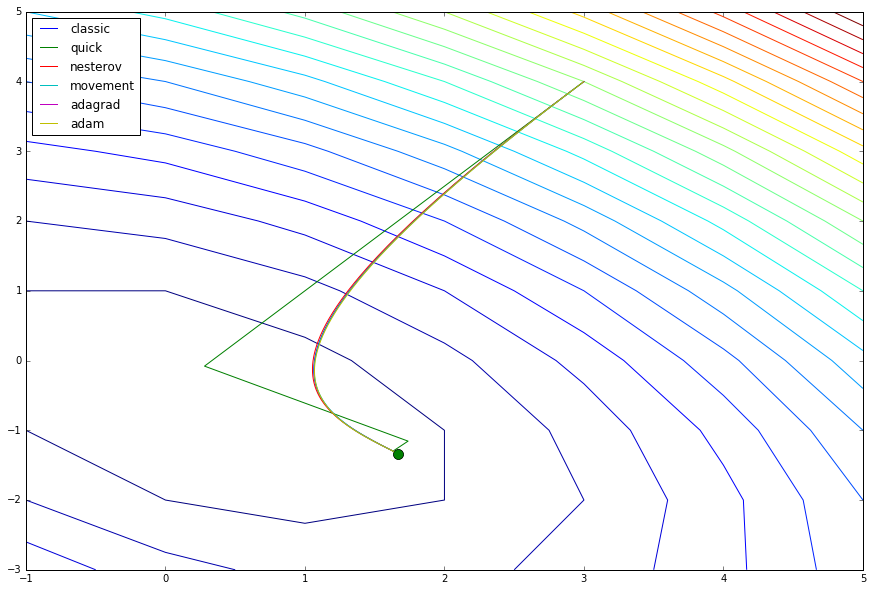

In [712]:
def compute_grad(x):
    return np.array([2*x[0] + x[1] - 2, x[0] + 2*x[1] + 1])
    
def function_val(x):
    return x[0] ** 2 + x[1]*x[0] + x[1] ** 2 - 2*x[0] + x[1]

def grad_descent(theta, n_iter, alpha):
    history = [[], []]
    for i in range(n_iter):
        history[0].append(theta[0])
        history[1].append(theta[1])
        theta = theta - alpha * compute_grad(theta)
    return theta, history

theta_classic, hist_classic = grad_descent([3,4], 30000, 0.01)

                

def quickest_descent(theta, n_iter, alpha):
    history = [[], []]
    for i in range(n_iter):
        history[0].append(theta[0])
        history[1].append(theta[1])
        temp_max = 10 ** 10
        
        for i in range(1,100):
            if (temp_max > function_val(theta - i *0.01 * compute_grad(theta))):
                temp_max = function_val(theta - i *0.01 * compute_grad(theta))
                alpha = i * 0.01
        
        theta = theta - alpha * compute_grad(theta)
    return theta, history

theta_quick, hist_quick= quickest_descent(np.array([3,4]), 30000, 0.01)


def grad_des_movement(n_iter, alpha, theta, y):
    history = [[],[]]
    s = 0
    
    for i in range(n_iter):
        s =  -y*s - alpha * compute_grad(theta)
        theta = theta + s
        history[0].append(theta[0])
        history[1].append(theta[1])
    return theta, history
theta_move, hist_move = grad_des_movement(30000, 0.01, np.array([3,4]), 0.2)

def grad_des_nesterov(n_iter, alpha, theta, y):
    history = [[],[]]
    s = 0
    
    for i in range(n_iter):
        s =  -y*s - alpha * compute_grad(theta - s)
        theta = theta + s
        history[0].append(theta[0])
        history[1].append(theta[1])
    return theta, history
theta_nest, hist_nest = grad_des_nesterov(30000, 0.01, np.array([3,4]), 0.2)

def adagrad(theta, alpha, num_iters):
    history = [[],[]]
    g = 0
    
    for i in range(num_iters):
        Q = compute_grad(theta)
        #temp_x.append(Q)
        g += Q.dot(Q.T)   
        theta = theta - (alpha/(g **1/2 + 0.01)) * Q;
        history[0].append(theta[0])
        history[1].append(theta[1])
    return theta, history

theta_adagrad, hist_adagrad = adagrad(np.array([3,4]), 0.01, 30000)


def adam(theta, alpha, num_iters, forget_gate, lamb):
    history = [[], []]
    g = 0
    s = 0
    for i in range(num_iters):
        Q = compute_grad(theta)
        #temp_x.append(Q)
        g = lamb * g + (1 - lamb)*Q.dot(Q.T)
        s = forget_gate * s + (alpha/((g **1/2 + 0.01))) * Q
        theta = theta - s;
        history[0].append(theta[0])
        history[1].append(theta[1])
    return theta, history

theta_adam, hist_adam = adam(np.array([3,4]), 0.01, 30000, 0.2, 0.3)


plt.figure(figsize=(15,10))
def makeData():
    x = [i for i in range(-1,6)]
    y = [i for i in range(-3,6)]
    xgrid, ygrid = np.meshgrid(x, y)

    zgrid = ygrid ** 2 + xgrid ** 2 + xgrid * ygrid + ygrid - 2
    return xgrid, ygrid, zgrid

x, y, z = makeData()
cs = pylab.contour(x, y, z, 30)
plt.plot([5/3],[-4/3],marker="o", markersize=10, color="green")
plt.plot(hist_classic[0], hist_classic[1], label="classic")
plt.plot(hist_quick[0], hist_quick[1], label="quick")
plt.plot(hist_nest[0], hist_nest[1], label="nesterov")
plt.plot(hist_move[0], hist_move[1], label="movement")
plt.plot(hist_adagrad[0], hist_adagrad[1], label="adagrad")
plt.plot(hist_adam[0], hist_adam[1], label="adam")
plt.plot([5/3],[-4/3],marker="o", markersize=10, color="green")
pylab.legend(loc=2)

In [713]:
history = [hist_adagrad, hist_adam,hist_classic,hist_nest, hist_move, hist_quick ]

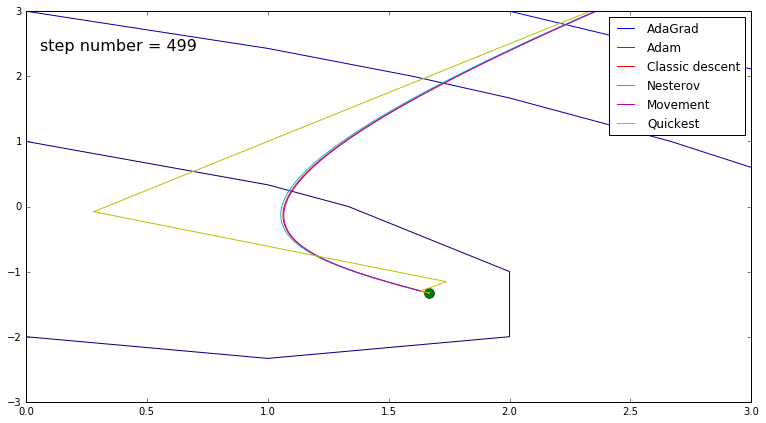

In [716]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots()

fig.set_size_inches(13, 7, True)
ax.set_xlim(( 0, 3))
ax.set_ylim((-3, 3))

def makeData():
    x = [i for i in range(-1,10)]
    y = [i for i in range(-3,10)]
    xgrid, ygrid = np.meshgrid(x, y)

    zgrid = ygrid ** 2 + xgrid ** 2 + xgrid * ygrid + ygrid - 2
    return xgrid, ygrid, zgrid

x, y, z = makeData()
cs = pylab.contour(x, y, z, 30)
plt.plot([5/3],[-4/3],marker="o", markersize=10, color="green")

colors = ['b','g','r', 'c','m','y']

time_text = ax.text(0.02, 0.9, '', transform=ax.transAxes, fontsize=16)

N = 6
lines = [plt.plot([], [])[0] for _ in range(N)]

def init():
    for line in lines:
        line.set_data([], [])
        
    lines[0].set_label("AdaGrad")
    lines[1].set_label("Adam")
    lines[2].set_label("Classic descent")
    lines[3].set_label("Nesterov")
    lines[4].set_label("Movement")
    lines[5].set_label("Quickest")
    pylab.legend()
    return lines

def animate(i):
    
    time_text.set_text('step number = %.1d' % i)
    
    num = 0
    for line in lines:
        line.set_data(history[num][0][:i], history[num][1][:i])
        num += 1
    
    return lines
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=40, blit=True)

HTML(anim.to_html5_video())